In [1]:
!wget https://www.eecs.yorku.ca/~bil/Datasets/for-rerec.tar.gz

--2024-03-27 15:25:56--  https://www.eecs.yorku.ca/~bil/Datasets/for-rerec.tar.gz
Resolving www.eecs.yorku.ca (www.eecs.yorku.ca)... 130.63.94.24
Connecting to www.eecs.yorku.ca (www.eecs.yorku.ca)|130.63.94.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1633453504 (1.5G) [application/x-tar]
Saving to: ‘for-rerec.tar.gz’

for-rerec.tar.gz    100%[===================>]   1.52G  81.1MB/s    in 18s     

2024-03-27 15:26:15 (85.5 MB/s) - ‘for-rerec.tar.gz’ saved [1633453504/1633453504]



In [2]:
!tar -xvf /content/for-rerec.tar.gz

Streaming output truncated to the last 5000 lines.
for-rerecorded/training/fake/recording2061.wav_norm_mono.wav
for-rerecorded/training/fake/recording2062.wav_norm_mono.wav
for-rerecorded/training/fake/recording2063.wav_norm_mono.wav
for-rerecorded/training/fake/recording2064.wav_norm_mono.wav
for-rerecorded/training/fake/recording2065.wav_norm_mono.wav
for-rerecorded/training/fake/recording2066.wav_norm_mono.wav
for-rerecorded/training/fake/recording2069.wav_norm_mono.wav
for-rerecorded/training/fake/recording2070.wav_norm_mono.wav
for-rerecorded/training/fake/recording2072.wav_norm_mono.wav
for-rerecorded/training/fake/recording2073.wav_norm_mono.wav
for-rerecorded/training/fake/recording2074.wav_norm_mono.wav
for-rerecorded/training/fake/recording2075.wav_norm_mono.wav
for-rerecorded/training/fake/recording2076.wav_norm_mono.wav
for-rerecorded/training/fake/recording2077.wav_norm_mono.wav
for-rerecorded/training/fake/recording2079.wav_norm_mono.wav
for-rerecorded/training/fake/recor

In [3]:
import librosa,os,multiprocessing
import librosa.display
import IPython.display as ipd
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import soundfile as sf
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [4]:
real='/content/for-rerecorded/training/real/recording10009.wav_norm_mono.wav'
ipd.Audio(real)

In [5]:
fake='/content/for-rerecorded/training/fake/recording1007.wav_norm_mono.wav'
ipd.Audio(fake)


**WAVEPLOT For fake**

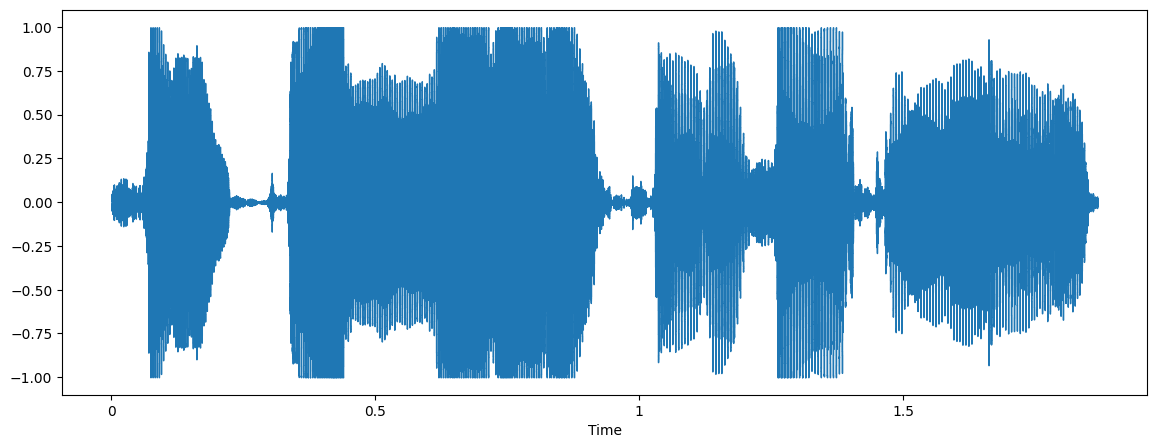

In [6]:
figure = plt.figure(figsize=(14,5))

audio, sample_rate = librosa.load(fake, sr=16000, duration=2)
librosa.display.waveshow(audio,sr=sample_rate)

**WAVEPLOT For real**

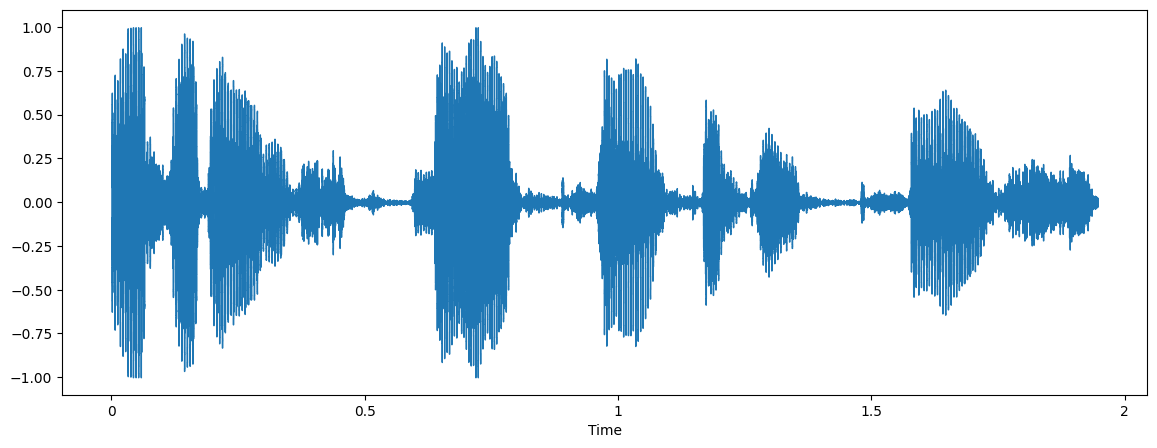

In [7]:
figure = plt.figure(figsize=(14,5))

audio, sample_rate = librosa.load(real, sr=16000, duration=2)
librosa.display.waveshow(audio,sr=sample_rate)

***SPECSHOW for real***

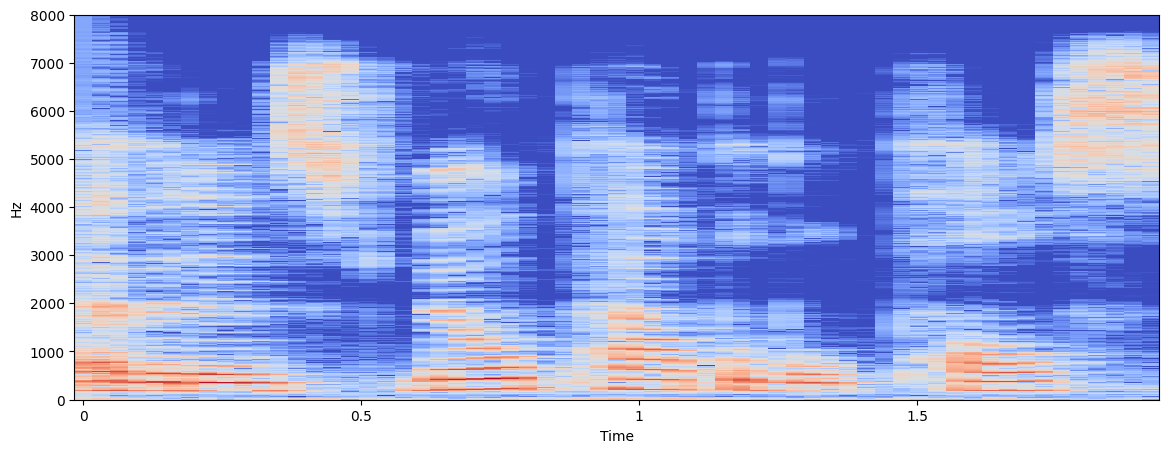

In [8]:
figure = plt.figure(figsize=(14,5))


audio, sample_rate = librosa.load(real, sr=16000, duration=2)
stft_audio = librosa.stft(audio)
Db_audio = librosa.amplitude_to_db(abs(stft_audio))
librosa.display.specshow(Db_audio,sr=sample_rate,x_axis="time",y_axis="hz")

***SPECSHOW for Fake***

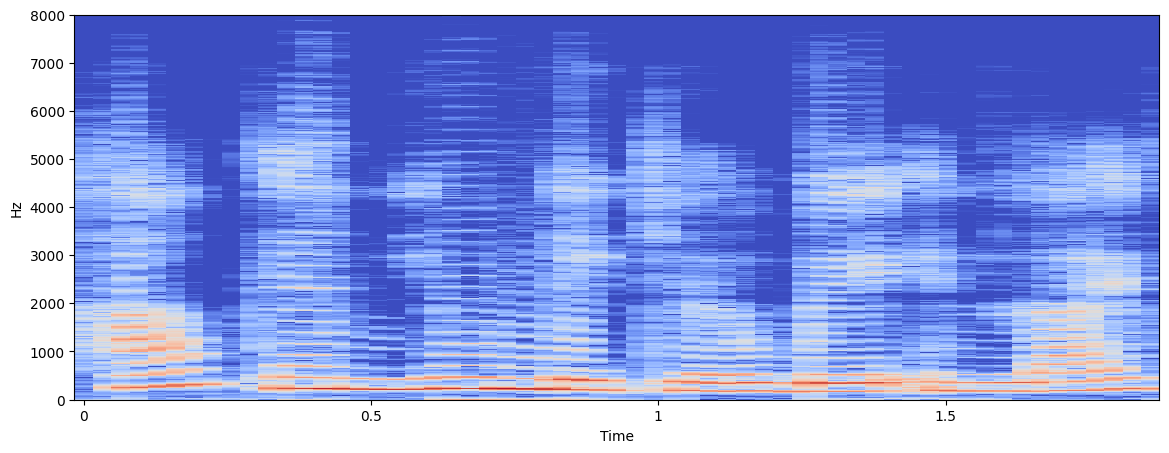

In [9]:
figure = plt.figure(figsize=(14,5))

audio, sample_rate = librosa.load(fake, sr=16000, duration=2)
stft_audio = librosa.stft(audio)
Db_audio = librosa.amplitude_to_db(abs(stft_audio))
librosa.display.specshow(Db_audio,sr=sample_rate,x_axis="time",y_axis="hz")

**MFCCs**

(13, 59)


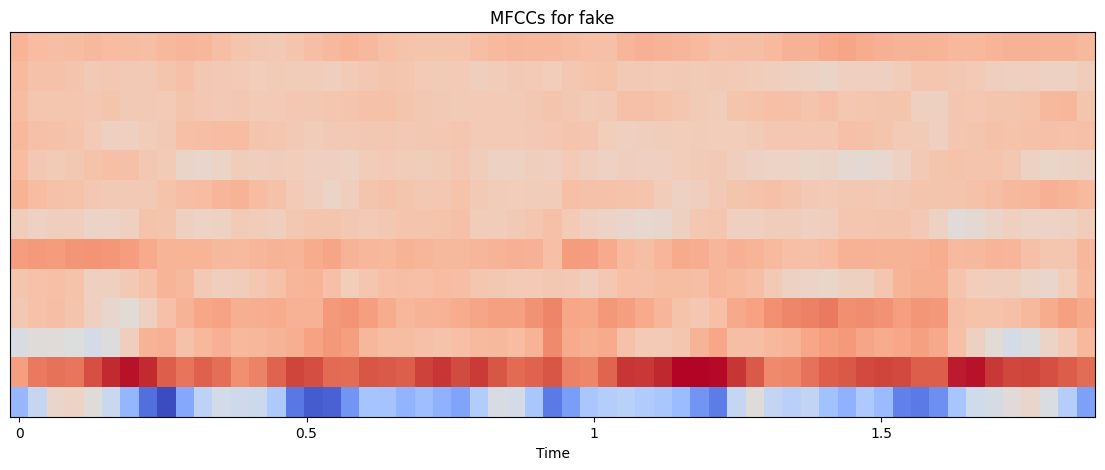

In [10]:
figure = plt.figure(figsize=(14,5))
audio, sample_rate = librosa.load(fake, sr=16000, duration=2)
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
plt.title("MFCCs for fake")
plt.show()

(13, 61)


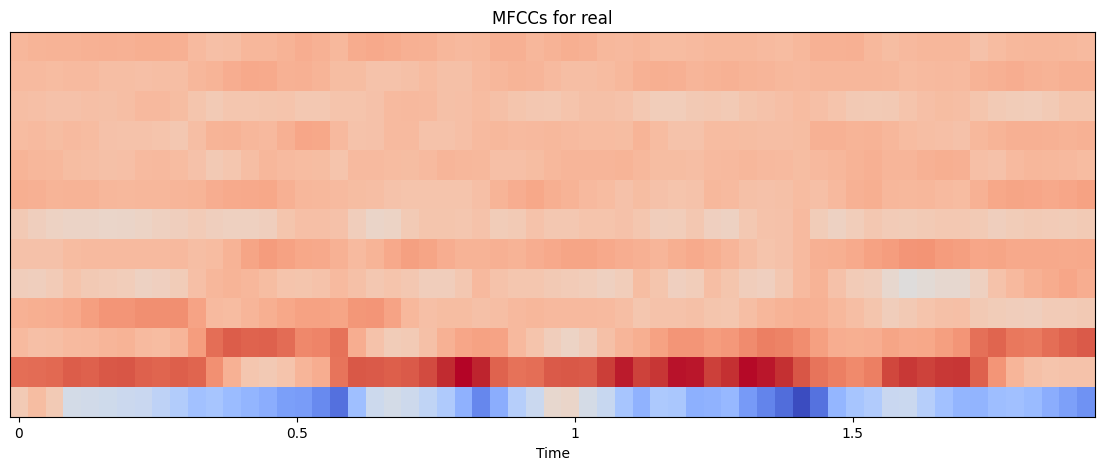

In [11]:
figure = plt.figure(figsize=(14,5))
audio, sample_rate = librosa.load(real, sr=16000, duration=2)
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
plt.title("MFCCs for real")
plt.show()

In [12]:
def load_data(base_path):
    features_list = []
    labels_list = []

    def process_file(file_label, file_name):
        label = [0, 1] if file_label == 'fake' else [1, 0]
        audio_file_path = os.path.join(base_path, file_label, file_name)
        features = extract_features(audio_file_path)
        return features, label

    num_cores = multiprocessing.cpu_count()
    results = Parallel(n_jobs=num_cores)(
        delayed(process_file)(file_label, file_name)
        for file_label in os.listdir(base_path)
        for file_name in os.listdir(os.path.join(base_path, file_label))
    )

    for features, label in results:
        features_list.append(features)
        labels_list.append(label)

    return features_list, labels_list


In [13]:
def extract_features(file_path, target_duration=2, sr=44100):
    try:
        # Load audio file
        audio, sample_rate = librosa.load(file_path, sr=sr)

        # Check if the length of audio is greater than 0
        if len(audio) > 0:
            # Ensure target duration
            target_length = target_duration * sr
            if len(audio) < target_length:
                audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
            elif len(audio) > target_length:
                audio = audio[:target_length]

            # Feature extraction
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
            mfccs_mean = np.mean(mfccs, axis=1)

            mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr), axis=1)
            chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr, n_chroma=12).T, axis=0)
            rms = np.mean(librosa.feature.rms(y=audio))
            zero_crossings = np.mean(librosa.feature.zero_crossing_rate(y=audio))

            # Concatenate all features into a single array
            features = np.concatenate((mfccs_mean, mel_spectrogram, chroma, [rms, zero_crossings]))

            return features
        else:
            print("Error: Audio length is 0.")
            return None

    except Exception as e:
        # Handle any exceptions that might occur during feature extraction
        print(f"Error in feature extraction: {e}")
        return None


In [14]:
# Training dataset
train_path = '/content/for-rerecorded/training'
X_train,y_train=load_data(train_path)
print("Done with Train Data")
# Validation dataset
val_path = '/content/for-rerecorded/validation'
X_val,y_val=load_data(val_path)
print("Done with Test Data")
# Testing dataset
test_path = '/content/for-rerecorded/testing'
X_test,y_test=load_data(test_path)
print("Done with Test Data")

Done with Train Data
Done with Test Data
Done with Test Data


In [15]:
len(X_train),len(X_test),len(y_train),len(y_test),len(X_val),len(y_val)

(10208, 816, 10208, 816, 2244, 2244)

In [16]:
print(np.shape(X_test))
xTest = np.expand_dims(X_test,axis=2)

(816, 182)


In [17]:
xTrain = np.expand_dims(X_train,axis=2)
xVal = np.expand_dims(X_val,axis=2)
xTest = np.expand_dims(X_test,axis=2)

In [18]:
print(xTrain.shape)
print(xVal.shape)

(10208, 182, 1)
(2244, 182, 1)


In [19]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout,BatchNormalization

In [20]:
model = Sequential()
model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(182, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 180, 128)          512       
                                                                 
 max_pooling1d (MaxPooling1  (None, 90, 128)           0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 90, 128)           512       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 88, 64)            24640     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 44, 64)            0         
 g1D)                                                            
                                                        

In [21]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
Y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

In [22]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=64, validation_data=(X_val, Y_val))

Epoch 1/64
319/319 [==============================] - 11s 8ms/step - loss: 0.6580 - accuracy: 0.7039 - val_loss: 0.4443 - val_accuracy: 0.7963
Epoch 2/64
319/319 [==============================] - 2s 7ms/step - loss: 0.4433 - accuracy: 0.8040 - val_loss: 0.2812 - val_accuracy: 0.8895
Epoch 3/64
319/319 [==============================] - 2s 8ms/step - loss: 0.3467 - accuracy: 0.8575 - val_loss: 0.2383 - val_accuracy: 0.9095
Epoch 4/64
319/319 [==============================] - 2s 6ms/step - loss: 0.3026 - accuracy: 0.8779 - val_loss: 0.1761 - val_accuracy: 0.9358
Epoch 5/64
319/319 [==============================] - 2s 7ms/step - loss: 0.2757 - accuracy: 0.8908 - val_loss: 0.1789 - val_accuracy: 0.9519
Epoch 6/64
319/319 [==============================] - 2s 6ms/step - loss: 0.2398 - accuracy: 0.9061 - val_loss: 0.1504 - val_accuracy: 0.9479
Epoch 7/64
319/319 [==============================] - 2s 6ms/step - loss: 0.2294 - accuracy: 0.9137 - val_loss: 0.1581 - val_accuracy: 0.9519
Epoch

<Axes: >

<Figure size 1000x1000 with 0 Axes>

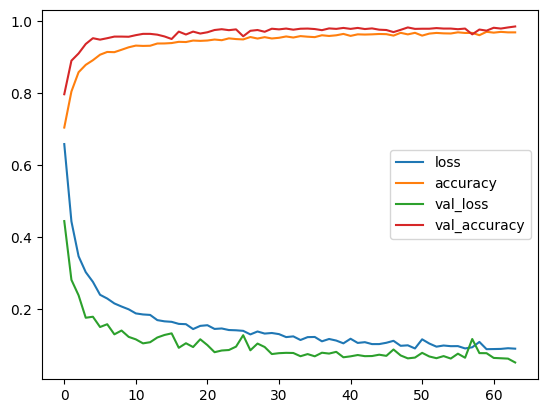

In [23]:
Grap_Data = pd.DataFrame(history.history)
figure = plt.figure(figsize=(10,10))
Grap_Data.plot()

In [24]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

26/26 [==============================] - 0s 9ms/step - loss: 0.2747 - accuracy: 0.8885
Test accuracy: 0.8884803652763367
